In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
import itertools

import warnings
warnings.filterwarnings('ignore')

### 1. Прочитайте базу my_PJME_MW.csv и сделайте ее перерасчет (ресемплинг) в представление по 1 месяцу.

In [2]:
df = pd.read_csv('my_PJME_MW.csv', index_col=[0], parse_dates=[0])

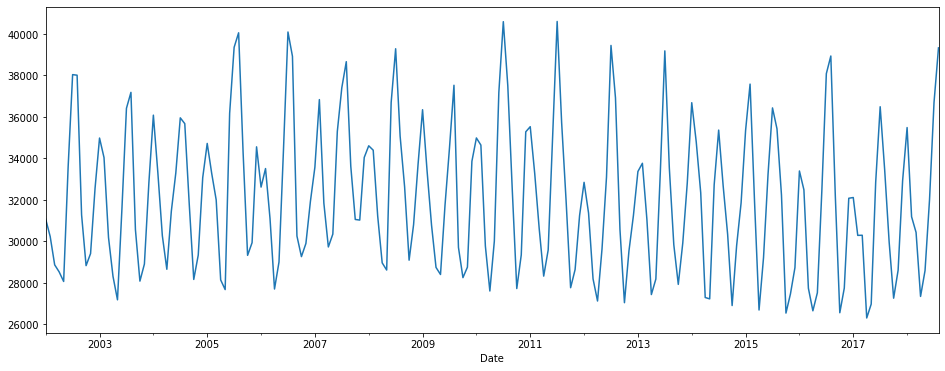

In [3]:
data = df.resample('M').mean()
data['PJME_MW'].plot(figsize=(16,6))

### 2. Подберите параметры модели SARIMAX для этого ряда.

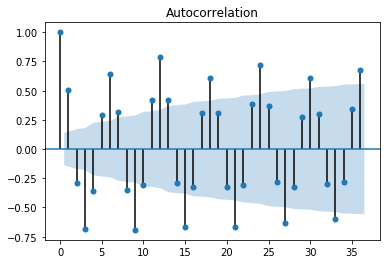

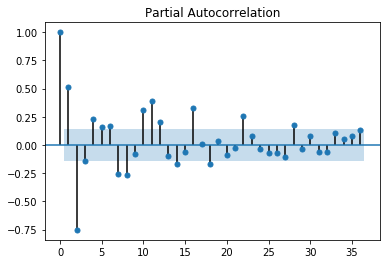

In [4]:
sm.graphics.tsa.plot_acf(data['PJME_MW'].values, lags=12*3)
plt.show()

sm.graphics.tsa.plot_pacf(data['PJME_MW'].values, lags=12*3)
plt.show()

In [100]:
# Исходя из ACF возьмем значения q (1, 3, 6)
# Для PACF p (1, 2)
# Намеренно уменьшил сетку поиска ради скорости.

In [97]:
p = [0, 1]
d = [0, 1]
q = [1, 3, 6]
pdq = list(itertools.product(p, d, q))     

In [98]:
p = [0, 1]
d = [1, 2]
q = [1, 2]
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [99]:
min_aic = np.inf

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(data['PJME_MW'].values[:-12],order=param,
                                    seasonal_order=param_seasonal ,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

            results = mod.fit()
            
            
            if results.aic < min_aic:
                print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
                min_aic = results.aic
                best_params = param
                best_seasonal_params = param_seasonal
            
        except:
            continue

ARIMA(0, 0, 1)x(0, 1, 1, 12) - AIC:2890.4757577812434
ARIMA(0, 0, 1)x(0, 1, 2, 12) - AIC:2653.7508364113146
ARIMA(0, 0, 1)x(0, 2, 2, 12) - AIC:2539.383341772715
ARIMA(0, 0, 1)x(1, 2, 2, 12) - AIC:2535.3911621998636
ARIMA(0, 0, 3)x(0, 2, 2, 12) - AIC:2495.0958371991474
ARIMA(0, 0, 3)x(1, 2, 2, 12) - AIC:2492.7350590248216
ARIMA(0, 0, 6)x(0, 2, 2, 12) - AIC:2424.486985079154
ARIMA(0, 1, 3)x(0, 2, 2, 12) - AIC:2423.7907950099843
ARIMA(0, 1, 6)x(0, 2, 2, 12) - AIC:2397.7536532135737
ARIMA(0, 1, 6)x(1, 2, 2, 12) - AIC:2375.5660659274063


In [101]:
print('Лучшие параметры для ARIMA{}x{} - AIC:{}'.format(best_params, best_seasonal_params, min_aic))

Лучшие параметры для ARIMA(0, 1, 6)x(1, 2, 2, 12) - AIC:2375.5660659274063


In [102]:
model = sm.tsa.statespace.SARIMAX(data['PJME_MW'].values[:-12],order=best_params,
                                    seasonal_order=best_seasonal_params ,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

In [103]:
model_result = model.fit()

In [104]:
print('ARIMA{} - AIC:{}'.format(best_params, model_result.aic))

ARIMA(0, 1, 6) - AIC:2375.5660659274063


In [105]:
print(model_result.summary().tables[0],model_result.summary().tables[1])

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  188
Model:             SARIMAX(0, 1, 6)x(1, 2, 2, 12)   Log Likelihood               -1177.783
Date:                            Fri, 12 Jun 2020   AIC                           2375.566
Time:                                    15:09:08   BIC                           2404.394
Sample:                                         0   HQIC                          2387.280
                                            - 188                                         
Covariance Type:                              opg                                         
========================================================================================== ==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------

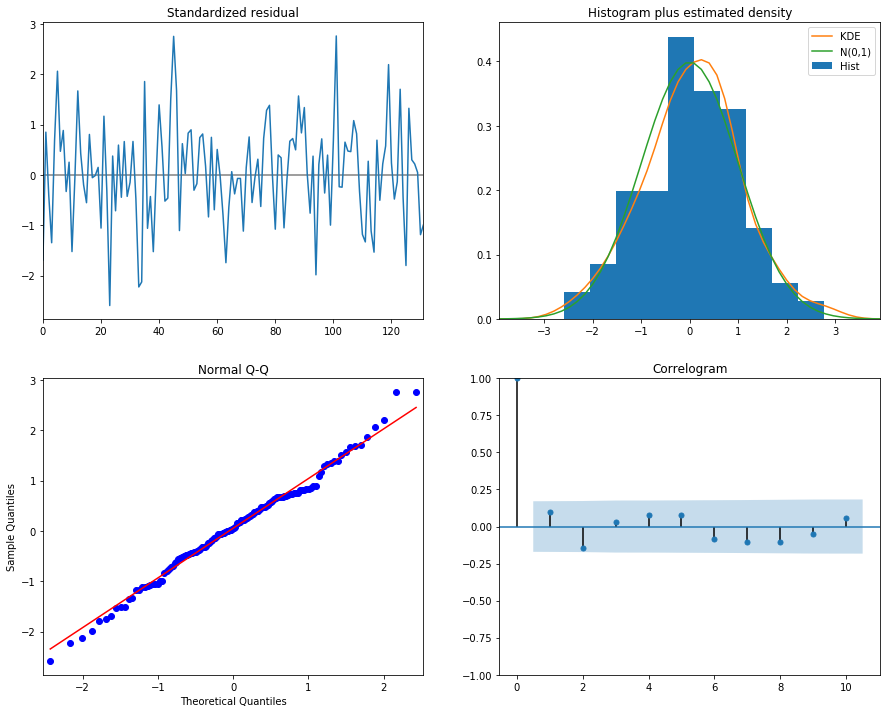

In [106]:
model_result.plot_diagnostics(figsize=(15, 12))
plt.show()

In [107]:
model_forecast = model_result.forecast(36)

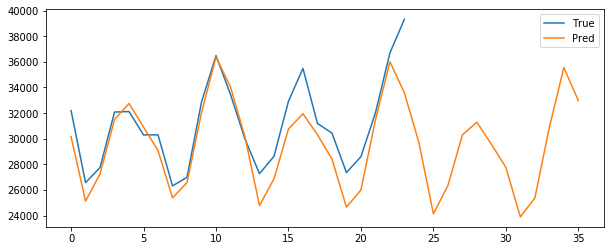

In [108]:
plt.figure(figsize=(10, 4))
plt.plot(data['PJME_MW'][-24:].values, label='True')
plt.plot(model_forecast, label='Pred')
plt.legend()


In [109]:
sm.tsa.stattools.adfuller(model_result.resid)

(-6.9395319557621935,
 1.03364691705824e-09,
 14,
 173,
 {'1%': -3.4687256239864017,
  '5%': -2.8783961376954363,
  '10%': -2.57575634100705},
 3134.5858327636543)

### 3. Сделайте вывод о том, как изменилась модель по сравнению с недельной.

Мы видим близкое к нулю p-value ADF теста близки к нулю, и можем считать остатки стационарным рядом <br>
Так же мы снова наблюдаем нормальное распределение <br>
График автокорреляции выглядит чуть лучше, чем на недельной выборке.

### 4. Постройте ACF, PACF и модель ARIMA для BRENT (недельный ресемплинг)

In [115]:
df = pd.read_csv('my_BRENT2019.csv', index_col=[0], parse_dates=[0])
df.head(2)

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Дата,,,,,,,,,,,
2010-09-01,76.37,2010,9,1,3,244,35,2,0,0,0
2010-09-02,76.89,2010,9,2,3,245,35,3,0,0,0


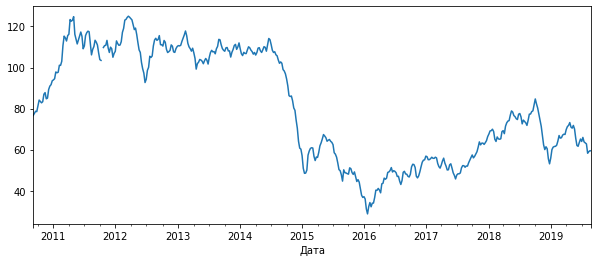

In [137]:
target = 'Значение'
data = df.resample('W').mean()
data[target].plot(figsize=(10, 4))

In [138]:
data.fillna(method='pad', inplace=True)

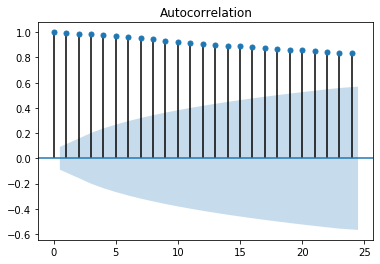

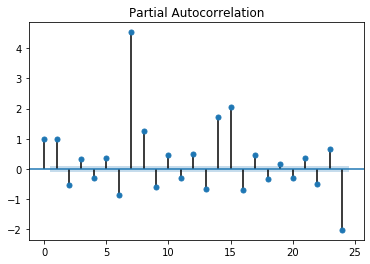

In [144]:
sm.graphics.tsa.plot_acf(data[target].values, lags=4*6)
plt.show()

sm.graphics.tsa.plot_pacf(data[target].values, lags=4*6)
plt.show()

In [145]:
p = d = q = range(4)
pdq = list(itertools.product(p, d, q))   

seasonal_pdq = [0, 0, 0, 0]

In [190]:
min_aic = np.inf

for param in pdq:
    param_seasonal = seasonal_pdq
    try:
        mod = sm.tsa.statespace.SARIMAX(data[target].values[:-26],order=param,
                                    seasonal_order=param_seasonal ,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

        results = mod.fit()
            
            
        if results.aic < min_aic:
            print('ARIMA{} - AIC:{}'.format(param, results.aic))
            min_aic = results.aic
            best_params = param
            best_seasonal_params = param_seasonal
            
    except:
        continue

ARIMA(0, 0, 0) - AIC:5206.183485066702
ARIMA(0, 0, 1) - AIC:4599.41603438759
ARIMA(0, 0, 2) - AIC:4051.138479897832
ARIMA(0, 0, 3) - AIC:3627.1262038988666
ARIMA(0, 1, 0) - AIC:1983.2190824115814
ARIMA(0, 1, 1) - AIC:1925.579748541184
ARIMA(0, 1, 2) - AIC:1923.935281435778
ARIMA(0, 1, 3) - AIC:1920.4247916157033
ARIMA(2, 1, 3) - AIC:1919.1795641398812
ARIMA(3, 1, 3) - AIC:1919.0493840525587


In [191]:
model_brent = sm.tsa.statespace.SARIMAX(data[target].values[:-26],order=best_params,
                                    seasonal_order=best_seasonal_params ,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

In [192]:
brent_result = model_brent.fit()
brent_result.aic

1919.0493840525587

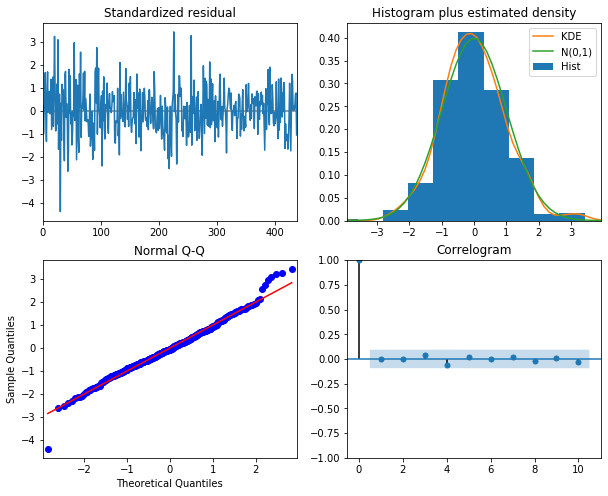

In [193]:
brent_result.plot_diagnostics(figsize=(10, 8))
plt.show()

### 5. Оцените результат моделирования

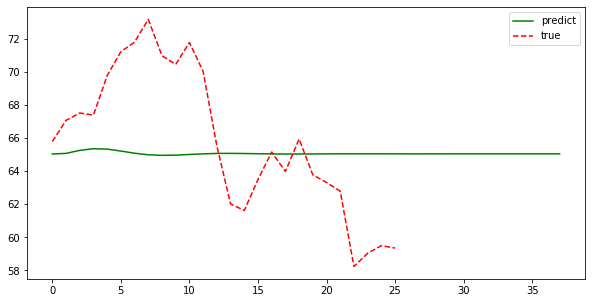

In [194]:
plt.figure(figsize=(10,5))
brent_fc = brent_result.forecast(38)
plt.plot(brent_fc,'g', label='predict' )
plt.plot(data[target].values[-26:],'--r',label='true')


plt.legend()

Данная модель не сработа на данных с нефтью, вместо прогноза мы получием усредненное значение за период.

### 6. Сделайте предположение о моделях, которые лучше работают с техниками регрессии на основе AR I MA.

In [ ]:
Данные модели хорошо работают с данными, обладающими сезонностью и без выбросов.